In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics
import json 
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pickle

%matplotlib inline


In [2]:
# read csv file into pandas dataframe 

df_users = pd.read_csv('relax_users_data.csv')

df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopt_status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [3]:
df_users.shape

(8823, 11)

In [4]:
df_users.dtypes

user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopt_status                    int64
dtype: object

In [5]:
df_users.adopt_status.value_counts(normalize=True)

0    0.812309
1    0.187691
Name: adopt_status, dtype: float64

In [6]:
df_users.groupby(['adopt_status']).last_session_creation_time.mean()

adopt_status
0    1.375596e+09
1    1.395221e+09
Name: last_session_creation_time, dtype: float64

In [7]:
df_users[['adopt_status','last_session_creation_time']].describe()

,adopt_status,last_session_creation_time
count,8823.000000,8.823000e+03
mean,0.187691,1.379279e+09
std,0.390488,1.953116e+07
min,0.000000,1.338452e+09
25%,0.000000,1.363195e+09
50%,0.000000,1.382888e+09
75%,0.000000,1.398443e+09
max,1.000000,1.402067e+09


In [8]:
df_users[df_users['adopt_status'] == 1].last_session_creation_time.describe()

count    1.656000e+03
mean     1.395221e+09
std      1.341866e+07
min      1.341244e+09
25%      1.399693e+09
50%      1.401256e+09
75%      1.401801e+09
max      1.401926e+09
Name: last_session_creation_time, dtype: float64

In [9]:
df_users[df_users['adopt_status'] == 0].last_session_creation_time.describe()

count    7.167000e+03
mean     1.375596e+09
std      1.886094e+07
min      1.338452e+09
25%      1.359985e+09
50%      1.377737e+09
75%      1.392963e+09
max      1.402067e+09
Name: last_session_creation_time, dtype: float64

## Convert Categorical Features

In [10]:
# https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02


cle = LabelEncoder()
df_users['creation_source_label'] = cle.fit_transform(df_users['creation_source'])

# convert string into date time object
df_users.creation_time = df_users.creation_time.apply(pd.to_datetime)

df_users.dtypes

user_id                                int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
adopt_status                           int64
creation_source_label                  int64
dtype: object

In [11]:
df_users.columns

Index([u'user_id', u'creation_time', u'name', u'email', u'creation_source',
       u'last_session_creation_time', u'opted_in_to_mailing_list',
       u'enabled_for_marketing_drip', u'org_id', u'invited_by_user_id',
       u'adopt_status', u'creation_source_label'],
      dtype='object')

In [12]:
df_users.describe()

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopt_status,creation_source_label
count,8823.000000,8.823000e+03,8823.000000,8823.000000,8823.000000,4776.000000,8823.000000,8823.000000
mean,6019.821716,1.379279e+09,0.252295,0.151989,142.572254,5980.495394,0.187691,1.807775
std,3464.251001,1.953116e+07,0.434354,0.359031,124.176422,3394.211361,0.390488,1.373882
min,1.000000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
25%,3017.500000,1.363195e+09,0.000000,0.000000,30.000000,3071.000000,0.000000,1.000000
50%,6034.000000,1.382888e+09,0.000000,0.000000,109.000000,5947.000000,0.000000,1.000000
75%,9029.500000,1.398443e+09,1.000000,0.000000,239.000000,8857.250000,0.000000,3.000000
max,12000.000000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000,4.000000


In [13]:
df_users.isna().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
adopt_status                     0
creation_source_label            0
dtype: int64

In [14]:
predictors = ['last_session_creation_time','opted_in_to_mailing_list',
              'enabled_for_marketing_drip', 'org_id','creation_source_label'] # 'invited_by_user_id',]

X = df_users[predictors]
y  = df_users.adopt_status

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

print(X_train.shape)
print
print(X_test.shape)

(7058, 5)

(1765, 5)


In [16]:
y_test.value_counts()

0    1425
1     340
Name: adopt_status, dtype: int64

## Logistic Regression Baseline Model

In [17]:
# Instantiate Logistic Regression Model
lr = LogisticRegression(random_state = 3)
# build the model using training data
lr.fit(X_train, y_train)
score = lr.score(X_test,y_test)
print(score)

0.8073654390934845


/Users/scottlew/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
# Generate Confusion Matrix for Decision Tree Classifier
actual = y_test
predictions = lr.predict(X_test)
print
cm_lr = confusion_matrix(actual,predictions)
print(cm_lr)


[[1425    0]
 [ 340    0]]


## More Classification Models

In [19]:
# Multinomail Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("MNB classifier Score: {:.2f}".format(mnb.score(X_test, y_test)))
print

MNB classifier Score: 0.57



In [20]:
# knn Classifier
#knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           #metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           #weights='uniform')
knn = KNeighborsClassifier( n_neighbors=5,weights='uniform')

knn.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("KNN classifier Score: {:.2f}".format(knn.score(X_test, y_test)))
print

KNN classifier Score: 0.88



In [21]:
# Generate Confusion Matrix for Decision Tree Classifier
actual = y_test
predictions_knn = knn.predict(X_test)
print
cm_knn = confusion_matrix(actual,predictions_knn)
print(cm_knn)


[[1350   75]
 [ 139  201]]


In [22]:
num_neighbors = [3,5,7,9,11,13,15,17]

for n_bors  in num_neighbors:
    knn = KNeighborsClassifier( n_neighbors=n_bors,weights='uniform')
    #knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           #metric_params=None, n_jobs=1, n_neighbors= n_bors, p=2,
           #weights='uniform')
    knn.fit(X_train, y_train)
    actual = y_test
    predictions_knn = knn.predict(X_test)
    print
    print('Number of Neighbors: ',n_bors)
    cm_knn = confusion_matrix(actual,predictions_knn)
    print(cm_knn)
    print
    
print('Done!')



('Number of Neighbors: ', 3)
[[1332   93]
 [ 142  198]]


('Number of Neighbors: ', 5)
[[1350   75]
 [ 139  201]]


('Number of Neighbors: ', 7)
[[1343   82]
 [ 136  204]]


('Number of Neighbors: ', 9)
[[1348   77]
 [ 135  205]]


('Number of Neighbors: ', 11)
[[1351   74]
 [ 138  202]]


('Number of Neighbors: ', 13)
[[1355   70]
 [ 135  205]]


('Number of Neighbors: ', 15)
[[1354   71]
 [ 137  203]]


('Number of Neighbors: ', 17)
[[1352   73]
 [ 136  204]]

Done!


In [23]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Decision Tree classifier Score: {:.2f}".format(dtc.score(X_test, y_test)))
print

Decision Tree classifier Score: 0.89



In [24]:
# Generate Confusion Matrix for Decision Tree Classifier
actual = y_test
predictions = dtc.predict(X_test)
print
cm_dtc = confusion_matrix(actual,predictions)
print(cm_dtc)


[[1346   79]
 [ 116  224]]


In [25]:
from sklearn.metrics import classification_report

dtc_prediction = dtc.predict(X_test)
print(classification_report(dtc_prediction, y_test))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1462
           1       0.66      0.74      0.70       303

   micro avg       0.89      0.89      0.89      1765
   macro avg       0.80      0.83      0.81      1765
weighted avg       0.90      0.89      0.89      1765



Text(0,0.5,'Features')

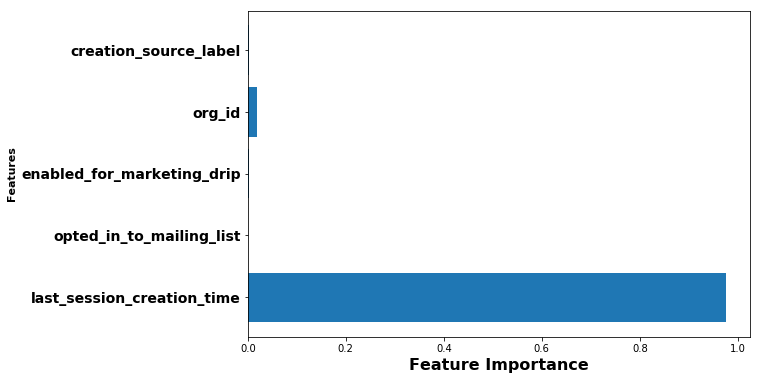

In [26]:
n_features = X.shape[1]

plt.figure(figsize=(9,6))
plt.barh(range(n_features), dtc.feature_importances_, align='center')
plt.yticks(np.arange(n_features),X.columns,fontsize=14,fontweight='bold')

plt.xlabel('Feature Importance',fontsize=16,fontweight='bold')
plt.ylabel('Features',fontsize=11,fontweight='bold')

#plt.savefig('XGBoost_Op_Feature_Importances.png')

In [27]:
# Random Forest Classifier
#rf = RandomForestClassifier(max_depth=5, n_estimators=100)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
# evaluate accuracy of our model on test data
print("Random Forest classifier Score: {:.2f}".format(rf.score(X_test, y_test)))
print

Random Forest classifier Score: 0.88



/Users/scottlew/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
# Generate Confusion Matrix for Random Forest Classifier
actual = y_test
predictions = rf.predict(X_test)
print
cm_rf = confusion_matrix(actual,predictions)
print(cm_rf)


[[1357   68]
 [ 141  199]]


In [29]:
# XGBoost Classifier

xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
print("XGBoost Classifier Score: {:.2f}".format(xgbc.score(X_test, y_test)))
print

XGBoost Classifier Score: 0.88



In [30]:
# Generate Confusion Matrix 
actual = y_test
predictions = xgbc.predict(X_test)
print('Confusion Matrix for XGBoost Model')
print
cm_xgbc = confusion_matrix(actual,predictions)
print(cm_xgbc)

Confusion Matrix for XGBoost Model

[[1349   76]
 [ 128  212]]


In [31]:
xgbc_prediction = xgbc.predict(X_test)
print(classification_report(xgbc_prediction, y_test))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1477
           1       0.62      0.74      0.68       288

   micro avg       0.88      0.88      0.88      1765
   macro avg       0.79      0.82      0.80      1765
weighted avg       0.89      0.88      0.89      1765



Text(0,0.5,'Features')

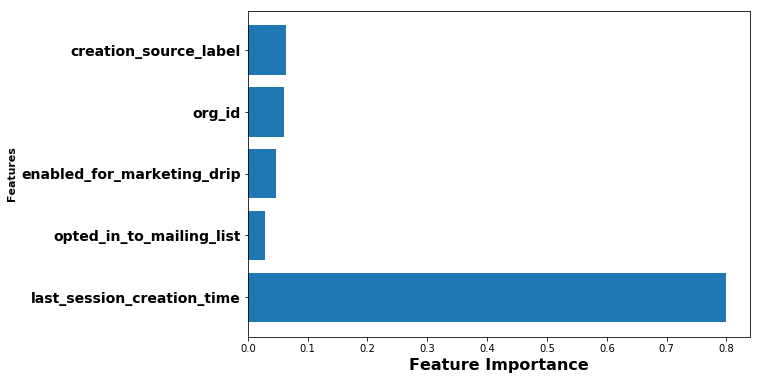

In [32]:
n_features = X.shape[1]

plt.figure(figsize=(9,6))
plt.barh(range(n_features), xgbc.feature_importances_, align='center')
plt.yticks(np.arange(n_features),X.columns)
plt.yticks(np.arange(n_features),X.columns,fontsize=14,fontweight='bold')

plt.xlabel('Feature Importance',fontsize=16,fontweight='bold')
plt.ylabel('Features',fontsize=11,fontweight='bold')
#plt.savefig('XGBoost_Op_Feature_Importances.png')

## Randomized Grid Search CV

In [33]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

classifier= XGBClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)

In [34]:
random_search.fit(X,y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   12.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'colsample_bytree': [0.3, 0.4, 0.5, 0.7], 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15], 'min_child_weight': [1, 3, 5, 7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

In [35]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=3, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [36]:
random_search.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 3}

In [37]:
# XGBoost Classifier

xgbc_OP = XGBClassifier(colsample_bytree=0.3, gamma=0.4, learning_rate=0.15,
       max_delta_step=0, max_depth=3, min_child_weight=3)

xgbc_OP.fit(X_train, y_train)

print("XGBoost Classifier Score: {:.2f}".format(xgbc_OP.score(X_test, y_test)))
print

XGBoost Classifier Score: 0.89



In [38]:
predictions = xgbc_OP.predict(X_test)
roc_auc_score(y_test, predictions)

0.7902115583075335

In [39]:
# Generate Confusion Matrix 
actual = y_test
predictions = xgbc_OP.predict(X_test)
print('Confusion Matrix for XGBoost Model')
print
cm_xgbc_op = confusion_matrix(actual,predictions)
print(cm_xgbc_op)

Confusion Matrix for XGBoost Model

[[1351   74]
 [ 125  215]]


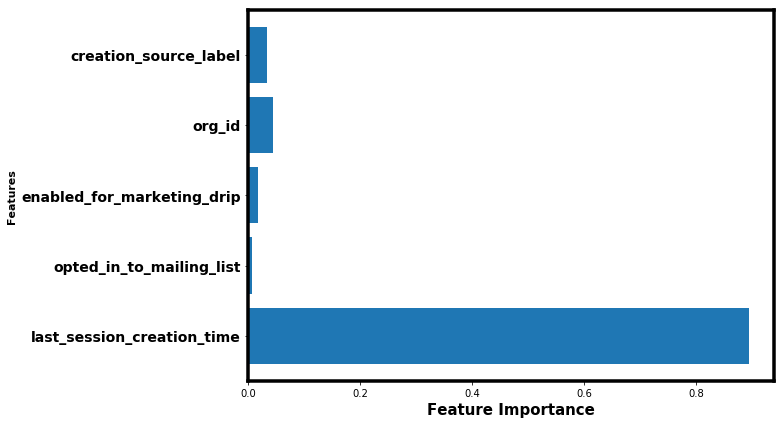

In [40]:
n_features = X.shape[1]

plt.figure(figsize=(11,6))
plt.barh(range(n_features), xgbc_OP.feature_importances_, align='center')
plt.yticks(np.arange(n_features),X.columns)
plt.yticks(np.arange(n_features),X.columns,fontsize=14,fontweight='bold')

plt.xlabel('Feature Importance',fontsize=15,fontweight='bold')
plt.ylabel('Features',fontsize=11,fontweight='bold')
# adjust line width of figure/graph frame,spines
plt.gca().spines['top'].set_linewidth(3.5)
plt.gca().spines['right'].set_linewidth(3.5)
plt.gca().spines['bottom'].set_linewidth(3.5)
plt.gca().spines['left'].set_linewidth(3.5)
plt.tight_layout()
#plt.savefig('Relax_XGBoost_Optimized_Feature_Importances.png')

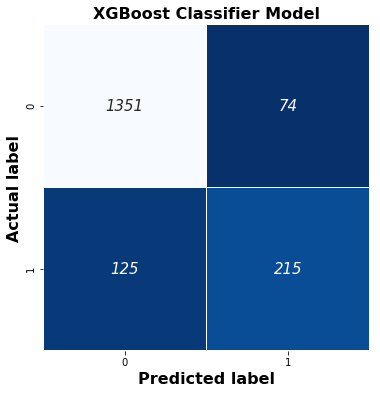

In [41]:
# Confusion matrix for XGBoost Classifier Model
plt.figure(figsize=(6,6))
annot_kws={'fontsize':15,'fontstyle':'italic'}
sns.heatmap(cm_xgbc_op, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar= None,annot_kws= annot_kws);
plt.ylabel('Actual label',fontsize=16,fontweight='bold');
plt.xlabel('Predicted label',fontsize=16,fontweight='bold');
plt.title('XGBoost Classifier Model',fontsize=16,fontweight='bold');
#plt.savefig('Relax_XGBoost_Optimized_Confusion_Matrix.png')

In [42]:
xgbc_prediction_opt = xgbc_OP.predict(X_test)
print(classification_report(xgbc_prediction_opt, y_test))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1476
           1       0.63      0.74      0.68       289

   micro avg       0.89      0.89      0.89      1765
   macro avg       0.79      0.83      0.81      1765
weighted avg       0.90      0.89      0.89      1765

